# Example 2: An Illustration of Recovery for a Function with Variable Interactions

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context(
    "notebook", rc={"axes.linewidth": 2, "grid.linewidth": 1}, font_scale=1.5
)

import numpy as np
from itertools import product

import nshap

### The data

In [2]:
np.random.seed(123)
mean = np.zeros(2)
scale = np.eye(2)
scale[0, 1] = 0.3
scale[1, 0] = 0.3
print(scale)

X_train = np.random.multivariate_normal(mean, scale, size=1000)
X_test = np.random.multivariate_normal(mean, scale, size=1000)

[[1.  0.3]
 [0.3 1. ]]


### The function

In [3]:
def f(x):
    if x.ndim == 2:
        x = x[0]
    return 0.5 * x[0] + x[0] * x[1]


f(X_test[0])

2.6115419587693616

### This function consists mostly of variable interaction of order 2, so the partial dependence plots of Shapley Values don't have any clear structure

In [4]:
vfunc = nshap.vfunc.interventional_shap(f, X_train)


In [5]:
n_shapley_values = []
for x in X_test:
    n_shapley_values.append(nshap.n_shapley_values(x, vfunc))


In [6]:
shapley_values = n_shapley_values[0].shapley_values()
# plot with shap package
import shap

shap.initjs()
shap.force_plot(
    np.mean([f(x) for x in X_train]), shapley_values, ["Feature 1", "Feature 2"]
)

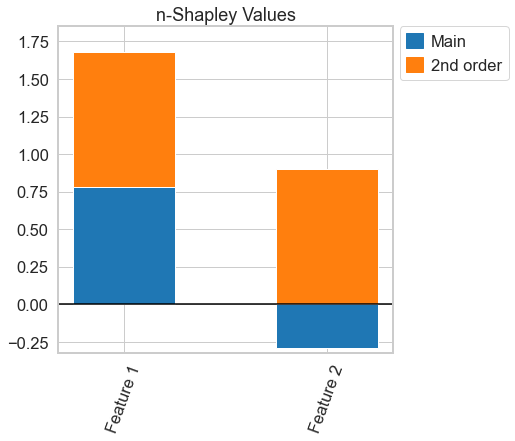

In [7]:
n_shapley_values[0].plot()
plt.show()


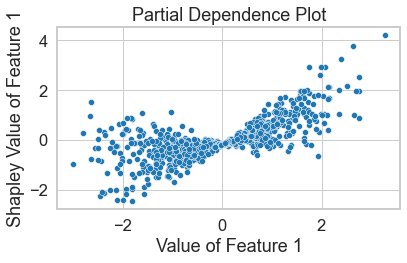

In [8]:
sns.scatterplot(
    x=[x[0] for x in X_test], y=[x.shapley_values()[0][0] for x in n_shapley_values]
)
plt.xlabel("Value of Feature 1")
plt.ylabel("Shapley Value of Feature 1")
plt.title("Partial Dependence Plot")
plt.tight_layout()
plt.show()

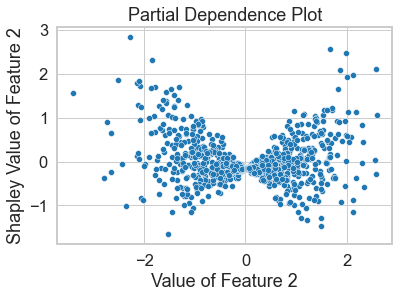

In [9]:
sns.scatterplot(
    x=[x[1] for x in X_test], y=[x.shapley_values()[0][1] for x in n_shapley_values]
)
plt.xlabel("Value of Feature 2")
plt.ylabel("Shapley Value of Feature 2")
plt.title("Partial Dependence Plot")
plt.show()

### 2-Shapley Values provide a representation of the function as a GAM

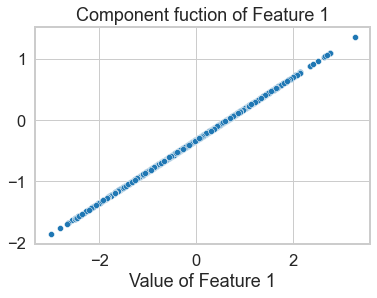

In [17]:
sns.scatterplot(x=[x[0] for x in X_test], y=[x[(0,)] for x in n_shapley_values])
plt.xlabel("Value of Feature 1")
plt.title("Component fuction of Feature 1")
ylim = plt.ylim()
plt.show()

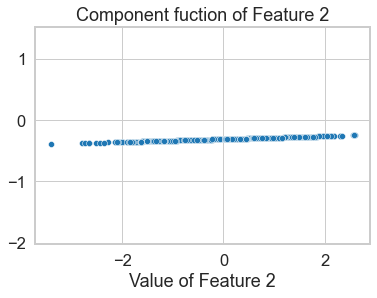

In [18]:
sns.scatterplot(x=[x[1] for x in X_test], y=[x[(1,)] for x in n_shapley_values])
plt.xlabel("Value of Feature 2")
plt.title("Component fuction of Feature 2")
plt.ylim(ylim)
plt.show()

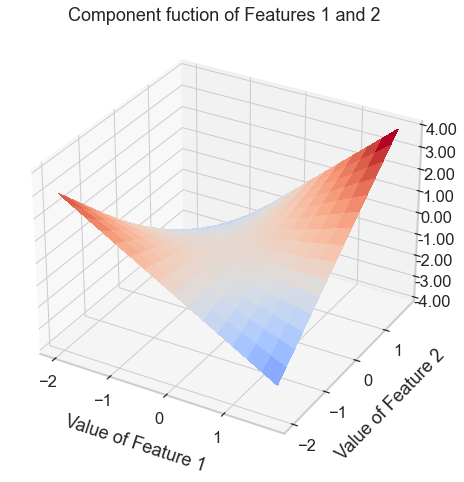

In [12]:
X = np.arange(-2, 2, 0.25)
Y = np.arange(-2, 2, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.array(
    [f(np.array([X[i, j], Y[i, j]])) for i, j in product(range(16), range(16))]
).reshape((16, 16))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-4, 4)
ax.zaxis.set_major_formatter("{x:.02f}")
plt.xlabel("Value of Feature 1", labelpad=15)
plt.ylabel("Value of Feature 2", labelpad=15)
plt.title("Component fuction of Features 1 and 2")
plt.show()